In [88]:
from streaming.models.inputs import SimulationMeasurements
from streaming.models import stream
import numpy as np
import matplotlib.pyplot as plt
from nbodykit.lab import cosmology
import read_clpt 
from scipy.optimize import curve_fit
import pickle
import json


In [85]:
import matplotlib.font_manager
import matplotlib as mpl
mpl.style.use('~/StreamingModel/streaming/utils/mplstyle')
from streaming.utils import plot_tools as pt


In [86]:
pdf_filename = "../data/pairwise_velocity_pdf.hdf5"
tpcf_filename = "../data/tpcf.hdf5"
simulation = SimulationMeasurements(pdf_filename, tpcf_filename)

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/h5py-2.9.0-py3.6-linux-x86_64.egg/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [87]:
clpt_dir = '/cosma/home/dp004/dc-cues1/CLPT_GSRSD/'


In [91]:
cosmo_dict = json.load( open( "../data/cosmology.json" ) )

linear_growth = cosmo_dict['growth']

In [92]:
r_clpt = read_clpt.r_binning()

In [93]:
r_fit_range = r_clpt > 10

def xi_clpt(r, f1, f2, fit_range = True):
    
    if fit_range:
        return read_clpt.tpcf_prediction(f1, f2, linear_growth)[r_fit_range]
    else:
        return read_clpt.tpcf_prediction(f1, f2, linear_growth)

In [94]:
# Fit
measured_tpcf =  simulation.tpcf.mean(r_clpt)     

popt, pcov = curve_fit(xi_clpt,r_clpt[r_fit_range], measured_tpcf[r_fit_range])

b1, b2, a = popt

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [95]:
def mean_clpt(r, f1, f2):
    
    return read_clpt.weighted_mean_prediction(f1, f2, linear_growth)[r_fit_range]

In [96]:
r_fit_range = (r_clpt > 10) & (r_clpt < 80)


measured_mean = simulation.m_10.mean(r_clpt[r_fit_range])

popt_mean, pcov = curve_fit(mean_clpt,r_clpt[r_fit_range], measured_mean)

b1_mean, b2_mean = popt_mean

In [97]:
b2

-0.5919595580915333

Text(0,0.5,'Ratio')

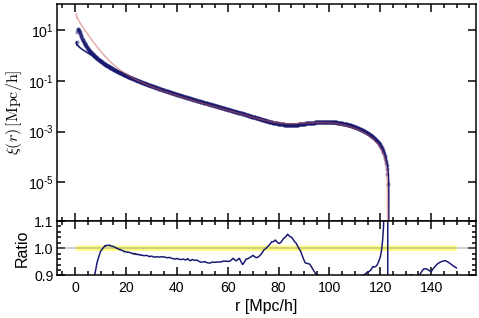

In [98]:
# Measure the real space correlation function w same binning
#plt.semilogy(r_clpt, measured_tpcf)
#plt.semilogy(r_clpt, xi_clpt(r_clpt, b1, b2, fit_range = False))


# --------------- Mean --------------------------------------
fig, axes = plt.subplots(nrows=2,
                         ncols=1,sharex=True,        
                         gridspec_kw = {'wspace':0, 'hspace':0, 'height_ratios':[4,1]})

axes[0].semilogy(r_clpt, 
             measured_tpcf,
            marker = 'o', linestyle = '',
              color = 'midnightblue', label = 'Radial', alpha = 0.4)
axes[0].plot(r_clpt, 
             xi_clpt(r_clpt, b1, b2, fit_range = False),
            color = 'midnightblue')

axes[0].plot(r_clpt, 
             xi_clpt(r_clpt, b1_mean, b2_mean, fit_range = False),
            color = 'indianred', alpha = 0.5)

axes[0].set_ylabel(r'$\xi(r) \, \mathrm{[Mpc/h]}$')

axes[1].fill_between(r_clpt,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
axes[1].axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

axes[1].plot(r_clpt, xi_clpt(r_clpt, b1, b2, fit_range = False) / measured_tpcf, 
         color = 'midnightblue')

axes[1].set_ylim(0.9,1.1)

axes[1].set_xlabel(r'r [Mpc/h]')
axes[1].set_ylabel(r'Ratio')


In [99]:
# Fitting the mean

In [100]:
# load clpt predictions
r_clpt, xi_clpt, v12_clpt, s12_par_clpt, s12_perp_clpt = read_clpt.weighted_perturbation_prediction(b1_mean,
                                                                                    b2_mean,linear_growth)

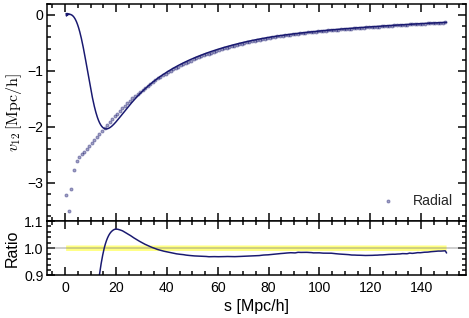

In [101]:
# --------------- Mean --------------------------------------
fig, axes = plt.subplots(nrows=2,
                         ncols=1,sharex=True,        
                         gridspec_kw = {'wspace':0, 'hspace':0, 'height_ratios':[4,1]})

axes[0].errorbar(simulation.r, 
             simulation.m_10.mean(simulation.r),
            marker = 'o', linestyle = '',
              color = 'midnightblue', label = 'Radial', alpha = 0.4)
axes[0].plot(r_clpt, 
             v12_clpt,
            color = 'midnightblue')

axes[0].set_ylabel('$v_{12} \, \mathrm{[Mpc/h]}$')

axes[1].fill_between(r_clpt,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
axes[1].axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

axes[1].plot(r_clpt, v12_clpt / simulation.m_10.mean(r_clpt), 
         color = 'midnightblue')

axes[1].set_ylim(0.9,1.1)

axes[1].set_xlabel(r's [Mpc/h]')
axes[1].set_ylabel(r'Ratio')
axes[0].legend(frameon=False)

In [102]:
# compute shift: sigma_fog
bin_100 = np.where(r_clpt > 100)[0][0]
sigma_fog_parallel = s12_par_clpt[bin_100] - simulation.c_20.mean(r_clpt[bin_100])
sigma_fog_perpendicular = s12_perp_clpt[bin_100] - simulation.c_02.mean(r_clpt[bin_100])

sigma_fog = -np.mean((sigma_fog_parallel, sigma_fog_perpendicular))

In [103]:
sigma_fog

-17.49281196100801

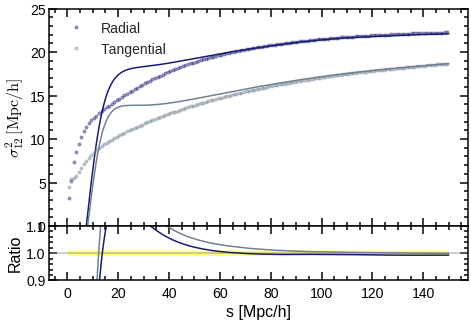

In [104]:
# --------------- STD --------------------------------------
fig, axes = plt.subplots(nrows=2,
                         ncols=1,sharex=True,        
                         gridspec_kw = {'wspace':0, 'hspace':0, 'height_ratios':[4,1]})

axes[0].errorbar(simulation.r, 
                simulation.c_20.mean(simulation.r),
                 marker = 'o', linestyle = '',
              color = 'midnightblue', label = 'Radial', alpha = 0.4)
axes[0].plot(r_clpt, 
             s12_par_clpt + sigma_fog,
            color = 'midnightblue')

axes[0].errorbar(simulation.r, 
             simulation.c_02.mean(simulation.r),
            marker = 'o', linestyle = '',
             color = 'slategray', label = 'Tangential', alpha = 0.4)
axes[0].plot(r_clpt, 
             s12_perp_clpt + sigma_fog,
            color = 'slategray')

axes[0].set_ylabel('$\sigma_{12}^2 \, \mathrm{[Mpc/h]}$')

axes[1].fill_between(r_clpt,0.99, 1.01, facecolor = 'yellow', alpha = 0.5)
axes[1].axhline(y = 1., linestyle='-', color='gray', alpha = 0.5)

axes[1].plot(r_clpt, (s12_par_clpt +sigma_fog) / simulation.c_20.mean(r_clpt), 
         color = 'midnightblue')

axes[1].plot(r_clpt, (s12_perp_clpt +sigma_fog) / simulation.c_02.mean(r_clpt), 
         color = 'slategray')

axes[1].set_ylim(0.9,1.1)
axes[0].set_ylim(0.,25.)

axes[1].set_xlabel(r's [Mpc/h]')
axes[1].set_ylabel(r'Ratio')
axes[0].legend(frameon=False)

In [44]:
clpt_params = {'b1': b1_mean,
                 'b2': b2_mean,
                'sigma_fog': sigma_fog,
              'linear_growth':linear_growth}

In [45]:
with open('clpt_params.pkl', 'wb') as f:
    pickle.dump(clpt_params, f)